In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
from tensorflow.keras import models, layers
from tensorflow.keras.applications import DenseNet121
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, f1_score, precision_score, recall_score

In [2]:
#check the gpu is available for training
print(tf.config.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
dataset_dir = "E:/Nigga/corndiseasedetection/corn/train"

In [6]:
test_dataset_dir = "E:/Nigga/corndiseasedetection/corn/test"
val_dataset_dir = "E:/Nigga/corndiseasedetection/corn/val"

In [7]:
image_size = 224
batch_size = 16
channel = 3
n_classes = 4

In [8]:
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    dataset_dir,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 3200 files belonging to 4 classes.


In [9]:
test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dataset_dir,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 400 files belonging to 4 classes.


In [10]:
val_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    val_dataset_dir,
    shuffle=True,
    image_size=(image_size, image_size),
    batch_size=batch_size
)

Found 400 files belonging to 4 classes.


In [11]:
class_names = train_dataset.class_names
class_names

['Healthy_Leaf', 'Leaf_Blight', 'Leaf_Rust', 'Leaf_Spot']

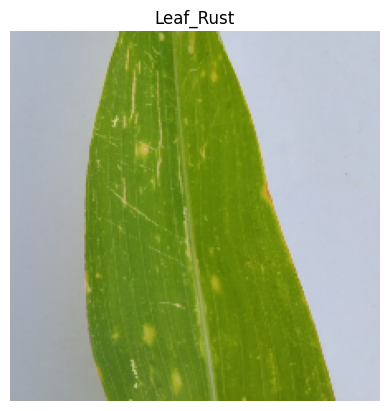

In [12]:
for image_batch,label_batch in train_dataset.take(1):
    plt.imshow(image_batch[0].numpy().astype("uint8"))
    plt.title(class_names[label_batch[0]])
    plt.axis("off")

In [13]:
train_dataset = train_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_dataset = test_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_dataset = val_dataset.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [14]:
len(train_dataset)

200

In [15]:
len(test_dataset)

25

In [16]:
len(val_dataset)

25

In [17]:
data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
    layers.RandomZoom(0.2),
    layers.RandomTranslation(height_factor=0.2, width_factor=0.2),
    layers.RandomBrightness(factor=0.2),
    layers.RandomContrast(factor=0.2)
])

In [18]:
train_dataset = train_dataset.map(
    lambda x, y: (data_augmentation(x, training=True), y)
).prefetch(buffer_size=tf.data.AUTOTUNE)

In [19]:
base_model = DenseNet121(
    weights='imagenet',
    include_top=False,
    input_shape=(image_size, image_size, channel)
)

In [20]:
base_model.trainable = False

In [21]:
model = models.Sequential(
    [
        layers.Rescaling(1.0 / 255),
        base_model,
        layers.GlobalAveragePooling2D(),
        layers.Dense(512, activation="relu"),
        layers.Dropout(0.5),
        layers.Dense(256, activation="relu"),
        layers.Dropout(0.3),
        layers.Dense(n_classes, activation="softmax"),
    ]
)

In [22]:
model.build(input_shape=(None,image_size,image_size,channel))

In [23]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         


                                                                 
 densenet121 (Functional)    (None, 7, 7, 1024)        7037504   
                                                                 
 global_average_pooling2d (G  (None, 1024)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               524800    
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 4)                 1028      
          

In [24]:
lr_reducer = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.3,
    patience=3,
    verbose=1,
)
early_stopper = EarlyStopping(monitor='val_loss', patience=10, verbose=1)

In [25]:
history = model.fit(
    train_dataset,
    batch_size=batch_size,
    validation_data=val_dataset,
    epochs=50,
    callbacks=[lr_reducer, early_stopper]
)

Epoch 1/50
200/200 [==============================] - 64s 132ms/step - loss: 0.9139 - accuracy: 0.6256 - val_loss: 0.3379 - val_accuracy: 0.8900 - lr: 1.0000e-04
Epoch 2/50
200/200 [==============================] - 21s 104ms/step - loss: 0.4759 - accuracy: 0.8278 - val_loss: 0.2362 - val_accuracy: 0.9150 - lr: 1.0000e-04
Epoch 3/50
200/200 [==============================] - 21s 104ms/step - loss: 0.3590 - accuracy: 0.8719 - val_loss: 0.2636 - val_accuracy: 0.8950 - lr: 1.0000e-04
Epoch 4/50
200/200 [==============================] - 21s 105ms/step - loss: 0.3010 - accuracy: 0.8875 - val_loss: 0.1824 - val_accuracy: 0.9225 - lr: 1.0000e-04
Epoch 5/50
200/200 [==============================] - 21s 107ms/step - loss: 0.2821 - accuracy: 0.8975 - val_loss: 0.1782 - val_accuracy: 0.9325 - lr: 1.0000e-04
Epoch 6/50
200/200 [==============================] - 22s 108ms/step - loss: 0.2467 - accuracy: 0.9131 - val_loss: 0.1774 - val_accuracy: 0.9275 - lr: 1.0000e-04
Epoch 7/50
200/200 [========

In [26]:
scores = model.evaluate(test_dataset)
print("Test Accuracy:", scores[1])

25/25 [==============================] - 5s 48ms/step - loss: 0.1877 - accuracy: 0.9350
Test Accuracy: 0.9350000023841858


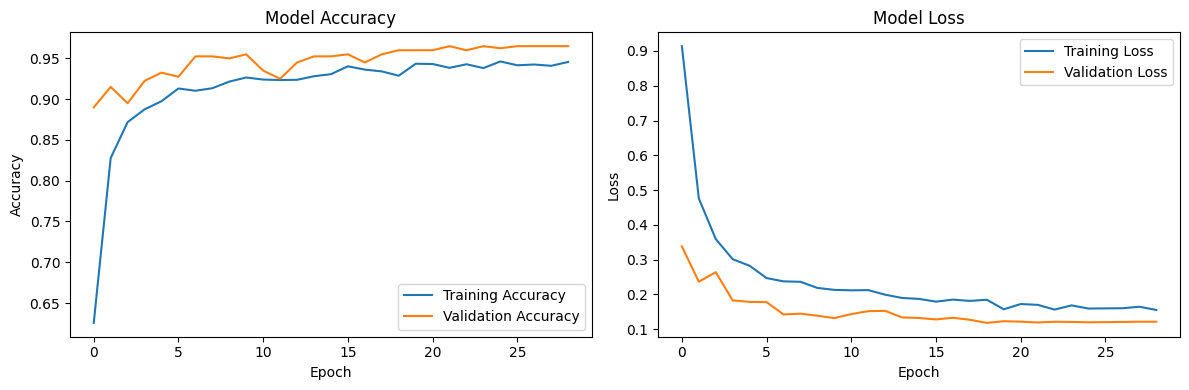

In [27]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.tight_layout()
plt.show()

In [28]:
def predict(model, image):
    img_array = tf.keras.preprocessing.image.img_to_array(image)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

1/1 [==============================] - 0s 32ms/step


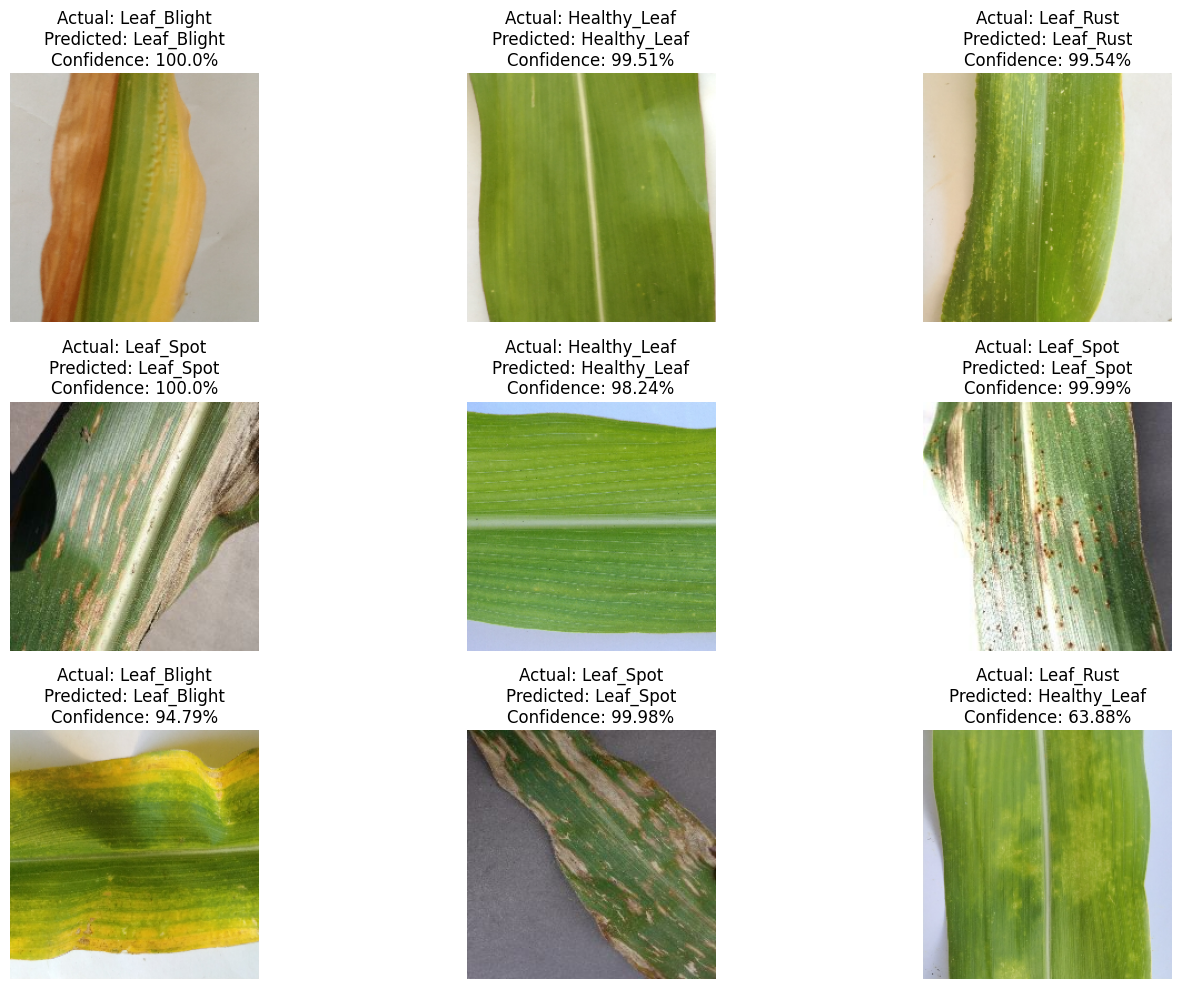

In [29]:
plt.figure(figsize=(15, 10))
for images, labels in test_dataset.take(1):
    for i in range(9):
        plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.tight_layout()

1/1 [==============================] - 0s 29ms/step


<Figure size 1000x800 with 0 Axes>

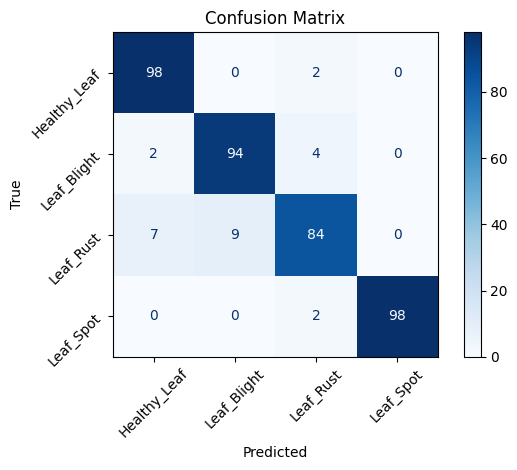

In [30]:
y_true = []
y_pred = []
for x, y in test_dataset:
    y_pred.extend(np.argmax(model.predict(x), axis=1))
    y_true.extend(y)

cm = confusion_matrix(y_true, y_pred, labels=[0, 1, 2, 3])

display_labels = [
    'Healthy_Leaf',
    'Leaf_Blight',
    'Leaf_Rust',
    'Leaf_Spot'
]

plt.figure(figsize=(10, 8))
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=display_labels)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('True')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [33]:
f1_scores = f1_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3])

print("F1 Scores:")
print("Healthy_Leaf:", f1_scores[0])
print("Leaf_Blight:", f1_scores[1])
print("Leaf_Rust:", f1_scores[2])
print("Leaf_Spot:", f1_scores[3])

macro_f1 = f1_score(y_true, y_pred, average='macro')
print("Macro-averaged F1 Score:", macro_f1)

F1 Scores:
Healthy_Leaf: 0.9468599033816426
Leaf_Blight: 0.9261083743842364
Leaf_Rust: 0.8749999999999999
Leaf_Spot: 0.98989898989899
Macro-averaged F1 Score: 0.9344668169162172


In [34]:
precision = precision_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3])
recall = recall_score(y_true, y_pred, average=None, labels=[0, 1, 2, 3])

print("Precision:")
print("Healthy_Leaf:", precision[0])
print("Leaf_Blight:", precision[1])
print("Leaf_Rust:", precision[2])
print("Leaf_Spot:", precision[3])

print("\nRecall:")
print("Healthy_Leaf:", recall[0])
print("Leaf_Blight:", recall[1])
print("Leaf_Rust:", recall[2])
print("Leaf_Spot:", recall[3])

Precision:
Healthy_Leaf: 0.9158878504672897
Leaf_Blight: 0.912621359223301
Leaf_Rust: 0.9130434782608695
Leaf_Spot: 1.0

Recall:
Healthy_Leaf: 0.98
Leaf_Blight: 0.94
Leaf_Rust: 0.84
Leaf_Spot: 0.98


In [35]:
model.save('corndisease_cb_densenet121.h5')

In [36]:
model.save('corndisease_cb_densenet121.keras')